In [223]:
import requests
import json
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

from PIL import Image
import os

import torch as th
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import transforms, datasets

In [156]:
id_data = pd.read_csv('id_df_final.csv')
id_data

,id,date_time,not_rain_pxl,sequence,rain_category
0,2455220,2024-10-26 14:00:00,195786,0,0
1,2455200,2024-10-26 13:50:00,195662,0,0
2,2455180,2024-10-26 13:40:00,195610,0,0
3,2455162,2024-10-26 13:30:00,195463,0,0
4,2455140,2024-10-26 13:20:00,195425,0,0
...,...,...,...,...,...
17664,1944353,2024-04-10 14:40:00,173612,176,3
17665,1944330,2024-04-10 14:30:00,172840,176,3
17666,1944313,2024-04-10 14:20:00,172292,176,3
17667,1944297,2024-04-10 14:15:00,176770,176,3


In [168]:
seq_len = id_data.groupby('sequence').size()
# convert to dictionary
seq_len = seq_len.to_dict()

seq_rain = id_data.groupby('sequence')['rain_category'].mean()
# convert to dictionary
seq_rain = seq_rain.to_dict()

In [169]:
seq_df = pd.DataFrame({'seq_len': seq_len, 'seq_rain': seq_rain})
display(seq_df)

,seq_len,seq_rain
0,83,1.855422
1,20,2.250000
2,57,1.350877
3,142,2.859155
4,29,4.000000
...,...,...
172,121,2.785124
173,200,2.570000
174,136,3.544118
175,15,0.400000


In order to normalise, we cannot directly divide the series of k images in train/test, because in this case some images of the same sequence may end up in both the train and test set.

That is why we divide in train/test the sequences and use the images of the train sequences to compute mean and std of the rgb values.

In [180]:
# split the sequences in train and test set (80/20)
train_seq = seq_df.sample(frac=0.8, random_state=4)
test_seq = seq_df.drop(train_seq.index)

print(train_seq['seq_len'].mean(), test_seq['seq_len'].mean())
print(train_seq['seq_len'].std(), test_seq['seq_len'].std())
print(train_seq['seq_rain'].mean(), test_seq['seq_rain'].mean())
print(train_seq['seq_rain'].std(), test_seq['seq_rain'].std())

# get the sequences of the train and test set
train_seq_idx = train_seq.index
test_seq_idx = test_seq.index

100.08450704225352 98.77142857142857
107.07878010295425 91.2775617406103
1.9481973131021486 1.9408190449957463
0.9659177456663836 0.9743946844194302


We get similar means and sd for the 2 sets, we are happy.

Now let's normalise the data using the test sequences.

In [192]:
train_data = id_data[id_data['sequence'].isin(train_seq_idx)]
train_data.shape

(14212, 5)

In [226]:
class RainDataset(th.utils.data.Dataset):
    def __init__(self, input_data, img_dir):
        self.input_data = input_data
        self.img_dir = img_dir
        self.transform = transforms.ToTensor()

    def __getitem__(self, index):
        # Get the row using the index
        row = self.input_data.iloc[index]
        
        # Define the image path
        # img_path = os.path.join(self.img_dir, f"{row['id']}.jpg")
        img_path = os.path.join(self.img_dir, "2447756_crop.jpg")
        
        # Load image with Pillow and convert it to RGB
        img = Image.open(img_path).convert("RGBA")

        img_tensor = self.transform(img)

        return img_tensor

    def __len__(self):
        return self.input_data.shape[0]
    
dataset = RainDataset(train_data[1:10], 'images/')

In [228]:
# mean of the 3 channels of image a
# mean of the first 2 dimensions of the image
a = dataset[0]
shape = a.shape
mean = th.zeros(4)
std = th.zeros(4)
sum = a.sum(dim=(1, 2))
sum = sum / (shape[1] * shape[2])
print(sum)

# std of the 3 channels of image a
# std of the first 2 dimensions of the image

sd = a[:,] - sum.view(4, 1, 1)
sd = sd * sd
sd = sd.sum(dim=(1,2))
sd = sd / (shape[1] * shape[2])
sd = th.sqrt(sd)
print(sd)

tensor([0.4345, 0.5121, 0.5294, 1.0000])
tensor([0.0900, 0.1108, 0.1612, 0.0000])


In [231]:
loader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

# Calculate mean and std
mean = th.zeros(4)
std = th.zeros(4)
for images in loader:

    sum = images.sum(dim=(0, 2, 3))
    len = images.size(0) * images.size(2) * images.size(3)
    mean += sum / len

    sd = images - mean.view(4, 1, 1)
    sd = sd * sd
    sum = sd.sum(dim=(0, 2, 3))
    std += th.sqrt(sum / len)

print(f"Mean: {mean}, Std: {std}")

std[3] = 0.001

Mean: tensor([0.4345, 0.5121, 0.5294, 1.0000]), Std: tensor([0.0900, 0.1108, 0.1612, 0.0000])


In [238]:
# Normalize the images
transform = transforms.Normalize(mean, std)
dataset = RainDataset(train_data[1:3], 'images/')
# apply transform to the dataset
loader = th.utils.data.DataLoader(dataset, batch_size=10, shuffle=False)
for batch_idx, images in enumerate(loader):
    images = transform(images)
    
    # Convert normalized images back to 0-255 range for saving
    images = (images * 255).clamp(0, 255).byte()
    
    # Save all images in the batch to a single output file, or loop for individual files
    for i in range(images.size(0)):
        image = Image.fromarray(tensor.permute(1, 2, 0).cpu().numpy())
        image.save(f"output_image_{i}.jpg")
        #save_image(images[i] / 255.0, f"images/output_image_{batch_idx * 10 + i}.png")

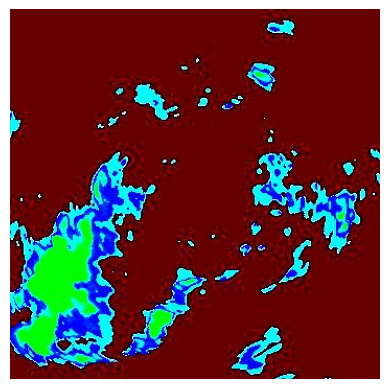

In [234]:
def print_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

print_image("images/output_image.")